In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim
import torch.autograd as autograd
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as pltimport 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [84]:
class Signal1DDataset(Dataset):
    def __init__(self, root_dir, params_csv, allowed_experiments=None,
                 normalize_signals=True, normalize_conditions=True):
        self.root_dir = root_dir
        self.params_df = pd.read_csv(params_csv)

        if allowed_experiments is not None:
            self.params_df = self.params_df[self.params_df["experiment"].isin(allowed_experiments)]

        self.samples = []
        for _, row in self.params_df.iterrows():
            folder_id = str(int(row["experiment"]))
            folder_path = os.path.join(root_dir, folder_id)
            if not os.path.isdir(folder_path):
                continue
            for fname in os.listdir(folder_path):
                if fname.lower().endswith(".csv"):
                    fpath = os.path.join(folder_path, fname)
                    conditions = row.drop("experiment").values
                    self.samples.append((fpath, conditions))

        print(f"Načteno {len(self.samples)} souborů (experiments={allowed_experiments})")

        # === globální normalizace signálů ===
        self.normalize_signals = normalize_signals
        if normalize_signals and len(self.samples) > 0:
            all_signals = []
            for fpath, _ in self.samples:
                df = pd.read_csv(fpath)
                if "intensity" in df.columns:
                    sig = df["intensity"].values.astype(np.float32)
                else:
                    sig = df.iloc[:, -1].values.astype(np.float32)
                all_signals.append(sig)

            all_signals = np.concatenate(all_signals)
            self.global_min = all_signals.min()
            self.global_max = all_signals.max()
            print(f"Globální normalizace: min={self.global_min:.4f}, max={self.global_max:.4f}")

        # === normalizace podmínek (conditions) ===
        self.normalize_conditions = normalize_conditions
        if normalize_conditions and len(self.samples) > 0:
            all_conditions = np.stack([s[1] for s in self.samples])
            self.cond_mean = all_conditions.mean(axis=0)
            self.cond_std = all_conditions.std(axis=0)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        signal_path, cond = self.samples[idx]
        df = pd.read_csv(signal_path)

        if "intensity" in df.columns:
            signal = df["intensity"].values.astype(np.float32)
        else:
            signal = df.iloc[:, -1].values.astype(np.float32)

        # globální normalizace
        if self.normalize_signals:
            signal = (signal - self.global_min) / (self.global_max - self.global_min + 1e-8)
            signal = signal * 2.0 - 1.0  # rozsah [-1, 1]

        # normalizace podmínek
        cond = cond.astype(np.float32)
        if self.normalize_conditions:
            cond = (cond - self.cond_mean) / (self.cond_std + 1e-8)

        return torch.from_numpy(signal), torch.from_numpy(cond)

    
    
class Generator1D(nn.Module):
    def __init__(self, noise_dim=64, cond_dim=5, signal_len=450):
        super().__init__()
        input_dim = noise_dim + cond_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, signal_len),
            nn.Tanh()   # výstup v intervalu [-1, 1]
        )

    def forward(self, noise, cond):
        x = torch.cat([noise, cond], dim=1)   # (B, noise_dim+cond_dim)
        return self.net(x)                    # (B, signal_len)




import torch
import torch.nn as nn

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator1D(nn.Module):
    def __init__(self, cond_dim=5, signal_len=450):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, stride=2, padding=3),
            nn.LeakyReLU(0.2),
            nn.Conv1d(16, 32, kernel_size=7, stride=2, padding=3),
            nn.LeakyReLU(0.2),
            nn.Conv1d(32, 64, kernel_size=7, stride=2, padding=3),
            nn.LeakyReLU(0.2),
        )

        # spočítáme velikost po konvolucích
        with torch.no_grad():
            dummy = torch.zeros(1, 1, signal_len)
            out = self.feature_extractor(dummy)
            flat_dim = out.view(1, -1).size(1)

        # plně propojené vrstvy
        self.fc1 = nn.Linear(flat_dim + cond_dim, 128)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(128, 1)

    def forward(self, signal, cond):
        x = signal.unsqueeze(1)       # (B, 1, L)
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)     # flatten
        x = torch.cat([x, cond], dim=1)
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.dropout(x)
        return self.out(x)
    



    

def train_wgan_gp_l1(G, D, train_loader, noise_dim, num_epochs=50,
                     lr_G=1e-4, lr_D=5e-5, device="cpu",
                     n_critic=2, lambda_gp=1.0, lambda_l1=10.0):
    """
    Hybridní trénink: WGAN-GP + L1 loss
    - G má dvě složky lossu: adversarial a L1 rekonstrukci
    """
    optimizer_G = optim.Adam(G.parameters(), lr=lr_G, betas=(0.0, 0.9))
    optimizer_D = optim.Adam(D.parameters(), lr=lr_D, betas=(0.0, 0.9))

    history = {"loss_D": [], "loss_G": []}

    for epoch in range(num_epochs):
        loss_D_epoch, loss_G_epoch = 0.0, 0.0

        for signals, conds in train_loader:
            signals = signals.to(device).float()
            conds = conds.to(device).float()
            b_size = signals.size(0)

            # --- trénujeme Critic ---
            for _ in range(n_critic):
                noise = torch.randn(b_size, noise_dim, device=device)
                fake_signals = G(noise, conds)

                D.zero_grad()
                real_validity = D(signals, conds)
                fake_validity = D(fake_signals.detach(), conds)

                gp = gradient_penalty(D, signals, fake_signals, conds, device, lambda_gp)
                loss_D = fake_validity.mean() - real_validity.mean() + gp

                loss_D.backward()
                optimizer_D.step()

            # --- trénujeme Generator ---
            noise = torch.randn(b_size, noise_dim, device=device)
            fake_signals = G(noise, conds)

            G.zero_grad()
            fake_validity = D(fake_signals, conds)

            # hybridní loss
            adv_loss = -fake_validity.mean()
            l1_loss = F.l1_loss(fake_signals, signals)  # párový L1 loss
            loss_G = adv_loss + lambda_l1 * l1_loss

            loss_G.backward()
            optimizer_G.step()

            loss_D_epoch += loss_D.item()
            loss_G_epoch += loss_G.item()

        # zprůměrování přes epochu
        loss_D_epoch /= len(train_loader)
        loss_G_epoch /= len(train_loader)
        history["loss_D"].append(loss_D_epoch)
        history["loss_G"].append(loss_G_epoch)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Loss_D: {loss_D_epoch:.4f} Loss_G: {loss_G_epoch:.4f}")

    return history

def gradient_penalty(D, real_data, fake_data, cond, device="cpu", lambda_gp=10):
    b_size = real_data.size(0)
    alpha = torch.rand(b_size, 1, device=device)
    alpha = alpha.expand_as(real_data)

    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    d_interpolates = D(interpolates, cond)

    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(b_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    gp = ((gradient_norm - 1) ** 2).mean() * lambda_gp
    return gp

def validate_gan(G, val_dataset, noise_dim=64, num_samples=5, device="cpu"):
    G.eval()
    indices = np.random.choice(len(val_dataset), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 8), sharex=True)
    for i, idx in enumerate(indices):
        real_signal, cond = val_dataset[idx]
        cond = cond.unsqueeze(0).to(device).float()
        noise = torch.randn(1, noise_dim, device=device)
        with torch.no_grad():
            fake_signal = G(noise, cond).cpu().numpy().flatten()

        axes[i].plot(real_signal.numpy(), label="Real", color="black")
        axes[i].plot(fake_signal, label="Generated", color="red", alpha=0.7)
        axes[i].legend()
    plt.suptitle("Validace: reálné vs. generované signály")
    plt.show()


Použité zařízení: cpu
Načteno 1027 souborů (experiments=[13  2 17 11 14 10 20 12 22  9  5  8  4  1  6 16  7])
Globální normalizace: min=0.0015, max=6.9025
Načteno 252 souborů (experiments=[15 19  3 21 18])
Globální normalizace: min=0.0016, max=5.5080
Init: noise_dim=64, cond_dim=5, signal_len=450
Epoch [1/90] Loss_D: -1.0426 Loss_G: 6.6645
Epoch [2/90] Loss_D: -2.0497 Loss_G: -6.3503
Epoch [3/90] Loss_D: 0.4611 Loss_G: -7.9150
Epoch [4/90] Loss_D: 0.4705 Loss_G: -2.3137
Epoch [5/90] Loss_D: 0.3884 Loss_G: -0.4216
Epoch [6/90] Loss_D: 0.1804 Loss_G: 0.2271
Epoch [7/90] Loss_D: 0.0748 Loss_G: 0.8496
Epoch [8/90] Loss_D: -0.0712 Loss_G: 1.0272
Epoch [9/90] Loss_D: 0.0651 Loss_G: -0.7291
Epoch [10/90] Loss_D: 0.1553 Loss_G: -3.5980
Epoch [11/90] Loss_D: 0.2346 Loss_G: -3.2763
Epoch [12/90] Loss_D: 0.1603 Loss_G: -1.7148
Epoch [13/90] Loss_D: 0.1711 Loss_G: -2.5441
Epoch [14/90] Loss_D: -0.0180 Loss_G: -2.4730
Epoch [15/90] Loss_D: -0.0251 Loss_G: -2.2032
Epoch [16/90] Loss_D: 0.0627 Loss_G

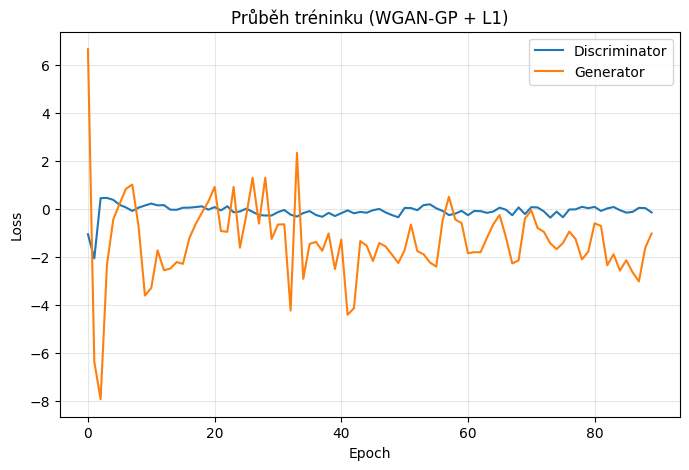

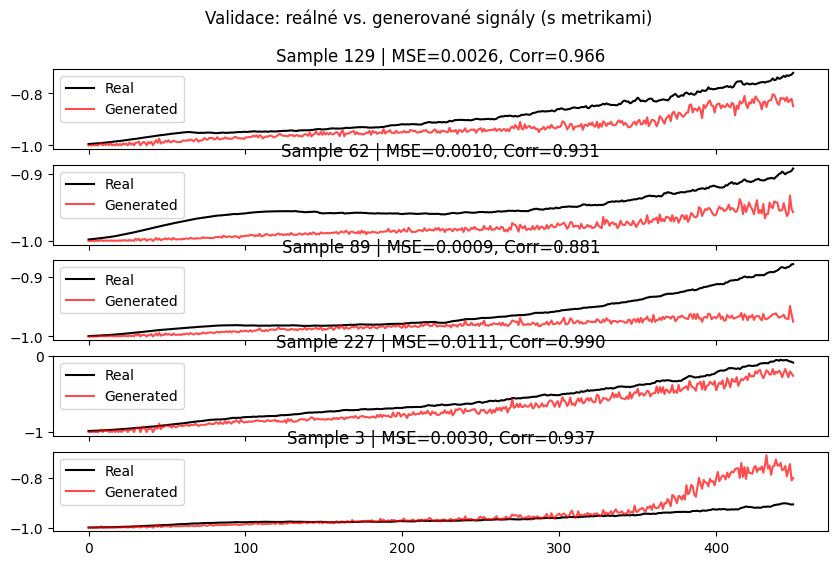

In [85]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt



if __name__ == "__main__":
    # ==========================
    # Nastavení
    # ==========================
    root_dir = "1D_spec"
    params_csv = "1D_spec/params.csv"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Použité zařízení:", device)

    # ==========================
    # Rozdělení experimentů train/val
    # ==========================
    params_df = pd.read_csv(params_csv)
    all_experiments = params_df["experiment"].unique()
    np.random.shuffle(all_experiments)

    split_ratio = 0.8
    split_idx = int(len(all_experiments) * split_ratio)
    train_exps = all_experiments[:split_idx]
    val_exps = all_experiments[split_idx:]

    train_dataset = Signal1DDataset(root_dir, params_csv, allowed_experiments=train_exps)
    val_dataset   = Signal1DDataset(root_dir, params_csv, allowed_experiments=val_exps)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # ==========================
    # Určení dimenzí
    # ==========================
    signal, cond = train_dataset[0]
    noise_dim = 64
    cond_dim = cond.numel()       # = 5 (z params.csv)
    signal_len = signal.numel()   # = 450

    print(f"Init: noise_dim={noise_dim}, cond_dim={cond_dim}, signal_len={signal_len}")

    # ==========================
    # Modely
    # ==========================
    G = Generator1D(noise_dim=noise_dim, cond_dim=cond_dim, signal_len=signal_len).to(device)
    D = Discriminator1D(cond_dim=cond_dim, signal_len=signal_len).to(device)


    # ==========================
    # Trénink
    # ==========================
    history = train_wgan_gp_l1(
        G, D, train_loader, noise_dim,
        num_epochs=90,          # zvýšeno na 200
        device=device,
        lr_G=1e-4, lr_D=5e-5,
        n_critic=2, lambda_gp=1.0, lambda_l1=10.0  # lambda_l1 sníženo z 50 → 10
    )

    # ==========================
    # Graf lossů
    # ==========================
    plt.figure(figsize=(8, 5))
    plt.plot(history["loss_D"], label="Discriminator")
    plt.plot(history["loss_G"], label="Generator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Průběh tréninku (WGAN-GP + L1)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # ==========================
    # Validace
    # ==========================
    def validate_gan_with_metrics(G, dataset, noise_dim=64, num_samples=3, device="cpu"):
        G.eval()
        indices = np.random.choice(len(dataset), num_samples, replace=False)
    
        fig, axes = plt.subplots(num_samples, 1, figsize=(10, 6), sharex=True)
    
        for i, idx in enumerate(indices):
            real_signal, cond = dataset[idx]
            real_signal = real_signal.numpy()
    
            cond = cond.unsqueeze(0).to(device).float()
            noise = torch.randn(1, noise_dim, device=device)
    
            with torch.no_grad():
                fake_signal = G(noise, cond).cpu().numpy().flatten()
    
            # metriky
            mse = mean_squared_error(real_signal, fake_signal)
            corr, _ = pearsonr(real_signal, fake_signal)
    
            axes[i].plot(real_signal, label="Real", color="black")
            axes[i].plot(fake_signal, label="Generated", color="red", alpha=0.7)
            axes[i].legend()
            axes[i].set_title(f"Sample {idx} | MSE={mse:.4f}, Corr={corr:.3f}")
    
        plt.suptitle("Validace: reálné vs. generované signály (s metrikami)")
        plt.show()
    
    validate_gan_with_metrics(G, val_dataset, noise_dim=noise_dim, num_samples=5, device=device)
